In [33]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [34]:
# !kaggle datasets download -d thedagger/pokemon-generation-one

In [35]:
# !unzip pokemon-generation-one.zip

In [36]:
path = '/content/dataset'
BATCH_SIZE = 32
SEED_VALUE = 42

In [37]:
train = image_dataset_from_directory(
    directory = path,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=SEED_VALUE,
    label_mode = 'int',
    subset='training',  # Training split
    validation_split = 0.2,
    image_size = (128,128)
)
val = image_dataset_from_directory(
    directory = path,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=SEED_VALUE,
    label_mode = 'int',
    subset='validation',
    validation_split = 0.2,
    image_size = (128,128)
)

class_names = train.class_names
class_idex = {s:i for i,s in enumerate(class_names)}
print(class_idex)

Found 10658 files belonging to 149 classes.
Using 8527 files for training.
Found 10658 files belonging to 149 classes.
Using 2131 files for validation.
{'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Arbok': 3, 'Arcanine': 4, 'Articuno': 5, 'Beedrill': 6, 'Bellsprout': 7, 'Blastoise': 8, 'Bulbasaur': 9, 'Butterfree': 10, 'Caterpie': 11, 'Chansey': 12, 'Charizard': 13, 'Charmander': 14, 'Charmeleon': 15, 'Clefable': 16, 'Clefairy': 17, 'Cloyster': 18, 'Cubone': 19, 'Dewgong': 20, 'Diglett': 21, 'Ditto': 22, 'Dodrio': 23, 'Doduo': 24, 'Dragonair': 25, 'Dragonite': 26, 'Dratini': 27, 'Drowzee': 28, 'Dugtrio': 29, 'Eevee': 30, 'Ekans': 31, 'Electabuzz': 32, 'Electrode': 33, 'Exeggcute': 34, 'Exeggutor': 35, 'Farfetchd': 36, 'Fearow': 37, 'Flareon': 38, 'Gastly': 39, 'Gengar': 40, 'Geodude': 41, 'Gloom': 42, 'Golbat': 43, 'Goldeen': 44, 'Golduck': 45, 'Golem': 46, 'Graveler': 47, 'Grimer': 48, 'Growlithe': 49, 'Gyarados': 50, 'Haunter': 51, 'Hitmonchan': 52, 'Hitmonlee': 53, 'Horsea': 54, 'Hyp

<h3>Show Sample Images from training set.</h3>

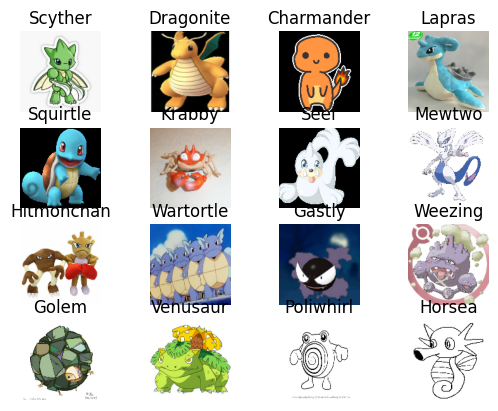

In [38]:
plt.Figure(figsize=(18,10))
num_row = 4
num_col = 4
for image,label in train.take(1):
    for i in range(num_row*num_col):
        ax = plt.subplot(num_row,num_col,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        truth_idx = label[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis('off')



<h3>Preprocessing.</h3>

In [39]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.applications.resnet50 import preprocess_input



# Apply the rescaling layer to your datasets
train_pre = train.map(lambda x, y: (preprocess_input(x), y))
val_pre = val.map(lambda x, y: (preprocess_input(x), y))

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),       # Randomly flip images horizontally
    RandomRotation(0.2),            # Randomly rotate images by up to 20%


])

# Apply augmentation to training dataset only
train_pre = train_pre.map(lambda x, y: (data_augmentation(x, training=True), y))

train_pre = train_pre.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_pre = val_pre.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [62]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract numeric labels from the training dataset
train_labels = []
for _, labels in train:  # `train` is the training dataset
    train_labels.extend(labels.numpy())  # Append all numeric labels

train_labels = np.array(train_labels)  # Convert to numpy array

# Compute class weights based on the extracted labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),  # Unique numeric labels
    y=train_labels  # Labels from the dataset
)

# Convert to a dictionary to pass to `fit`
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)


{0: 1.7341875127110027, 1: 0.7336947169161935, 2: 1.4307046979865772, 3: 1.1445637583892618, 4: 1.1679222024380222, 5: 1.2440910417274584, 6: 1.3625759028443591, 7: 1.10054207537429, 8: 1.1679222024380222, 9: 0.24881820834549168, 10: 1.10054207537429, 11: 1.467389433832387, 12: 1.4307046979865772, 13: 1.3958094614503191, 14: 0.2456145404268802, 15: 1.10054207537429, 16: 1.2717375093214018, 17: 1.059781257767835, 18: 1.1679222024380222, 19: 1.2440910417274584, 20: 1.1679222024380222, 21: 1.3308880911503043, 22: 1.5467077816071104, 23: 1.1221213317541783, 24: 1.467389433832387, 25: 1.10054207537429, 26: 1.1445637583892618, 27: 0.6812879514221796, 28: 1.1922539149888143, 29: 0.9699692867705608, 30: 1.5467077816071104, 31: 1.4307046979865772, 32: 1.3625759028443591, 33: 1.059781257767835, 34: 1.2717375093214018, 35: 1.0040032968326857, 36: 1.0040032968326857, 37: 0.6288811859281658, 38: 1.2176210195630444, 39: 1.4307046979865772, 40: 1.1922539149888143, 41: 1.2176210195630444, 42: 1.300640

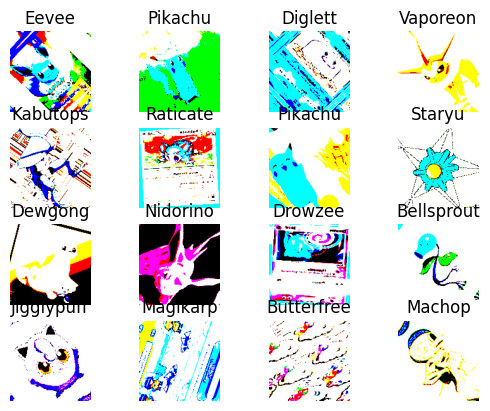

In [40]:
#checking images
plt.Figure(figsize=(18,10))
num_row = 4
num_col = 4
for image,label in train_pre.take(1):
    for i in range(num_row*num_col):
        ax = plt.subplot(num_row,num_col,i+1)
        plt.imshow(image[i].numpy())
        truth_idx = label[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis('off')



In [53]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
# Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = True

# Unfreeze only the top 4 layers (you can adjust this based on your needs)
for layer in base_model.layers[:-2]:  # Freeze all but the last few layers
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Add dropout after dense layer
    layers.Dense(len(class_names), activation='softmax')
])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [54]:
from tensorflow.keras.optimizers import RMSprop

# Recompile the model with a smaller learning rate
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 149)                 │          19,221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,869,205 (91.05 MB)

 Trainable params: 281,493 (1.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [56]:
history = model.fit(
    train,
    validation_data = val,
    epochs = 50,
    class_weight=class_weights_dict
)

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 110s 221ms/step - accuracy: 0.0465 - loss: 5.2224 - val_accuracy: 0.1534 - val_loss: 4.3504
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - accuracy: 0.1303 - loss: 4.4094 - val_accuracy: 0.2018 - val_loss: 3.7924
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 79s 154ms/step - accuracy: 0.1728 - loss: 3.9539 - val_accuracy: 0.2679 - val_loss: 3.3685
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 85s 164ms/step - accuracy: 0.2174 - loss: 3.6130 - val_accuracy: 0.3111 - val_loss: 3.1469
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - accuracy: 0.2509 - loss: 3.3773 - val_accuracy: 0.3083 - val_loss: 3.0340
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.2707 - loss: 3.2601 - val_accuracy: 0.3430 - val_loss: 2.9711
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.2852 - loss: 3.1453 - val_accuracy: 0.3749 - val_loss: 2.8146
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 85s 166ms/step - accuracy: 0.3106 - loss: 

In [ ]:
acc = model.evaluate(val)

In [ ]:
# model.save('/content/model_frozen_update.keras')